In [33]:
%matplotlib inline
%run ../skeleton.py
%run ../animation.py

In [34]:
skeleton = load_skeleton(r'../skeleton.dat')
animations = load_animations(r'all_moves_animations.dat')

#keep only animations of at least 15 frames
animations = [animation for animation in animations if animation[0] >= 15]

In [70]:
import k3d

def plot_skeleton(plot, skeleton):
    for i in range(len(skeleton._bones)):
        if skeleton._bones[i]._parentId >= 0:
            startM = skeleton.globalMatrix(i)
            endM = skeleton.globalMatrix(skeleton._bones[i]._parentId)
            p = k3d.line([startM[3][:3], endM[3][:3]], width=0.05, color=0x2233FF)
            plot += p

def plot_animation(plot, skeleton, animation):
    #plot skeleton at 2 frames
    keycount, tracks = animation
    skeleton.load_animation(animation, int(keycount/2) )
    plot_skeleton(plot, skeleton)

    
    #plot trajectories
    boneIds = [skeleton.bone_id(n) for n in ['Hips','LeftHand','RightHand','LeftFoot','RightFoot']]
    lines = [[] for i in range(len(boneIds))]
    for frame in range(keycount):
        skeleton.load_animation(animation, frame )
        for i,boneId in enumerate(boneIds):
            lines[i].append(skeleton.globalMatrix(boneId)[3][:3])
            
    for i in range(len(boneIds)):
        p = k3d.line(lines[i], shader='simple', color=0xFF22FF)
        plot += p
        
        
def plot_anchor(plot, skeleton):
    p = k3d.points([
            skeleton.anchorGlobalPosition(i) for i in range(len(skeleton._anchors))
        ], point_size=0.02, color=0x55FF00)
    plot += p
        
    
        
plot = k3d.plot()
plot_animation(plot, skeleton, animations[50])   
plot.display()

IndexError: list index out of range

In [ ]:
def point_cloud(skeleton):
    cloud = np.array([skeleton.anchorGlobalPosition(i) for i in range(len(skeleton._anchors))])
    average = np.average(cloud, axis=0)
    average[2] = 0
    return cloud - average

def point_cloud_and_average(skeleton):
    cloud = np.array([skeleton.anchorGlobalPosition(i) for i in range(len(skeleton._anchors))])
    average = np.average(cloud, axis=0)
    average[2] = 0
    return cloud, average

def rotate_cloud(cloud, theta):
    c, s = np.cos(theta), np.sin(theta)
    M = np.array([[c,-s,0],[s,c,0],[0,0,1]])
    return cloud.dot(M)

def align_cloud(cloud, x,y,t):
    cloud = rotate_cloud(cloud, t)
    return cloud + np.array([x,y,0])


def get_anim_cloud_from_animation(skeleton, animation):
    keycount_a, _ = animation
    anim_a_clouds = []
    anim_a_averages = []
    for frame in range(keycount_a):
        skeleton.load_animation(animation, frame)
        cloud, average = point_cloud_and_average(skeleton)
        anim_a_clouds.append(cloud)
        anim_a_averages.append(average)
    return anim_a_clouds, anim_a_averages

plot = k3d.plot()
plot_animation(plot, skeleton, animations[50])
clouds, averages = get_anim_cloud_from_animation(skeleton, animations[50])
for cloud in clouds:
    p = k3d.points([cloud], point_size=0.02, color=0x55FF00)
    plot += p
plot.display()


In [ ]:
from scipy.optimize import minimize

WRAP_LENGTH = 10

def is_looping_animation(skeleton, animation):
    keycount, _ = animation
    
    def _objective(xyt, cloud_a, cloud_b):
        cloud = align_cloud(cloud_b, *xyt)
        v = cloud_a - cloud
        return np.sum(v*v) * 0.5
    
    skeleton.load_animation(animation, 0)
    cloud_a = point_cloud(skeleton)
    skeleton.load_animation(animation, keycount-1)
    cloud_b = point_cloud(skeleton)
        
    extra = (cloud_a,cloud_b)
    sol = minimize(_objective, [0,0,0], method='SLSQP', args=extra)
    return sol.fun < 0.0001


def align_animations(skeleton, animation, animation_frame):
    
    def _objective(xyt, cloud_a, cloud_b):
        cloud = align_cloud(cloud_b, *xyt)
        v = cloud_a - cloud
        return np.sum(v*v) * 0.5

    #we will solve clouds for previous node and next node
    #the skeleton already holds the previous frame
    cloud_a, average_a = point_cloud_and_average(skeleton)
    #load the new animation
    skeleton.load_animation(animation, animation_frame)
    cloud_b, average_b = point_cloud_and_average(skeleton)

    #remove the average to help the minize function
    cloud_a -= average_a
    cloud_b -= average_b
    average = average_b-average_a

    #align
    sol = minimize(_objective, [0,0,0], method='SLSQP', args=(cloud_a, cloud_b))

    #build matrix out of our result
    x,y,theta = sol.x
    c, s = np.cos(theta), np.sin(theta)
    M = np.array([[c,-s,0,0],[s,c,0,0],[0,0,1,0],[0,0,0,1]], dtype=float)

    #move the world matrix
    skeleton.world[3][:3] -= average+np.array([x,y,0])

    #recompute the center of cloud
    skeleton.load_animation(animation, animation_frame)
    cloud_b, average_b = point_cloud_and_average(skeleton)

    #rotate the matrix around the center of the cloud
    skeleton.world[3][:3] -= average_b
    skeleton.world = skeleton.world.dot(M)
    skeleton.world[3][:3] += average_b


def create_looping_animation_track(skeleton, animation):
    #assuming a looping animation, we create a new animation with WRAP_LENGTH data in front and end
    tracks_buffer = skeleton.create_tracks_buffer()
    keycount, tracks = animation
    
    #store the last x frames
    skeleton.world = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]], dtype=float)
    for i in range(keycount-WRAP_LENGTH-1, keycount): #go one more frame because our last one is the first one of the next anim
        skeleton.load_animation(animation, i)
        skeleton.save_tracks(tracks_buffer)
        
    #align with the first frame
    align_animations(skeleton, animation, 0)
    
    #store the animation
    for i in range(1, keycount):
        skeleton.load_animation(animation, i)
        skeleton.save_tracks(tracks_buffer)
          
    #align with the first frame
    align_animations(skeleton, animation, 0)
    
    #store the end
    for i in range(1, WRAP_LENGTH+1):
        skeleton.load_animation(animation, i)
        skeleton.save_tracks(tracks_buffer)
        
        
    skeleton.world = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]], dtype=float)
    
    return (len(tracks_buffer[0][1]), tracks_buffer)


def create_non_looping_animation_track(skeleton, animation):
    #assuming an animation that do not loop, we generate an animation with static constant velocity before and after
    tracks_buffer = skeleton.create_tracks_buffer()
    keycount, tracks = animation
    
    skeleton.world = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]], dtype=float)
    skeleton.load_animation(animation, 1)
    _, average_a = point_cloud_and_average(skeleton)
    skeleton.load_animation(animation, 0)
    _, average_b = point_cloud_and_average(skeleton)
    average = average_a-average_b
    
    #store frame 0 sliding
    for i in range(WRAP_LENGTH):
        a = average*float(i)
        skeleton.world = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[a[0],a[1],0,1]], dtype=float)
        skeleton.save_tracks(tracks_buffer)
      
    #then store the current animation
    for i in range(0, keycount):
        skeleton.load_animation(animation, i)
        skeleton.save_tracks(tracks_buffer)
    
    #then keep storing the last frame with the slide
    for i in range(1,WRAP_LENGTH+1):
        a = average*float(WRAP_LENGTH+i)
        skeleton.world = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[a[0],a[1],0,1]], dtype=float)
        skeleton.save_tracks(tracks_buffer)
    
    return (len(tracks_buffer[0][1]), tracks_buffer)


def get_extended_cloud(skeleton, animation):
    extended_anim = None
    if is_looping_animation(skeleton, animation):
        extended_anim = create_looping_animation_track(skeleton, animation)
    else:
        extended_anim = create_non_looping_animation_track(skeleton, animation)
    return get_anim_cloud_from_animation(skeleton, extended_anim)

def _show_debug():
    plot = k3d.plot()
    plot_animation(plot, skeleton, animations[50])
    clouds, averages = get_extended_cloud(skeleton, animations[50])
    for cloud in clouds:
        p = k3d.points([cloud], point_size=0.02, color=0x55FF00)
        plot += p
    plot.display()
#_show_debug()



# Generate animation coulds

The clouds will be generated on a multiprocessor process. For this to run on windows, it has to run in a separate python process. So the entire code from this notebook up to this point has been placed inside the 'generate_couds.py' python file.

<b>There is no need to execute any previous code from this notebook to generate the clouds</b>

If you have to modify the list of animations to generate, make sure to change the code in the python file and not in this notebook.

At the end of this process we will have a dictionnary with the animations and the clouds as :<br>
animations_data = {
        'animations':animations, 
        'clouds':[None]*len(animations), 
        'looping':[False]*len(animations), 
        'match_start':[[] for i in range(len(animations))]
        }

In [190]:
%run generate_clouds.py
#the data is inside this dictionnary now

start multiprocessors for extended cloud
end multiprocessors for extended cloud
start multiprocessors for matches of non looping animation
end multiprocessors for matches of non looping animation


#### Store the generated clouds

In [191]:
import pickle
x = pickle.dumps(animations_data, protocol=2)
with open(r'all_animations_and_clouds.dat', 'wb') as f:
    f.write(x)

#### Load back generated clouds

In [159]:
import pickle
animations_data = pickle.load(open(r'all_animations_and_clouds.dat','rb'))
print (len(animations_data['animations']), len(animations_data['clouds']))

118 118


# Compare animations

Let's compare two animations using the generated clouds.
This time we will properly align all the clouds relative to the frame we are trying to compare.

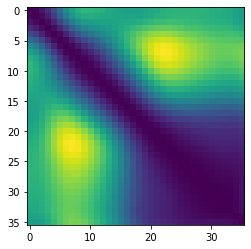

In [133]:
def compute_errors_between_2_animations(anim_a, clouds_and_averages_a, anim_b, clouds_and_averages_b):
    WRAP_OFFSET = 9
    
    keycount_a, _ = anim_a
    keycount_b, _ = anim_b
   
        
    def _objective(xyt, cloud_a, cloud_b, weights):
        cloud = align_cloud(cloud_b, *xyt)
        v = cloud_a - cloud
        sqr = np.sum(v*v, axis=1)
        return np.sum(sqr * weights) * 0.5
    
    def _concat(arg, arg2):
        a = np.concatenate((arg[0],arg2[0]), axis=0)
        b = np.concatenate((arg[1],arg2[1]), axis=0)
        w = np.concatenate((arg[2],arg2[2]))
        return (a,b,w)
    
    def _build_lists(frame_a, frame_b, weight):
        a = clouds_and_averages_a[0][frame_a]
        b = clouds_and_averages_b[0][frame_b]
        w = np.array([weight]*a.shape[0])
        return (a,b,w)
    
    errors = []
    for frame_a in range(WRAP_OFFSET, keycount_a+WRAP_OFFSET):
        errors.append([])
        for frame_b in range(WRAP_OFFSET, keycount_b+WRAP_OFFSET):
               
            arg = _build_lists(frame_a, frame_b, 1.0)
            
            arg2 = _build_lists(frame_a-1, frame_b-1, 0.8)
            arg = _concat(arg2, arg)
                
            arg2 = _build_lists(frame_a-2, frame_b-2, 0.5)
            arg = _concat(arg2, arg)
                
            arg2 = _build_lists(frame_a-3, frame_b-3, 0.3)
            arg = _concat(arg2, arg)
                
            arg2 = _build_lists(frame_a+1, frame_b+1, 0.8)
            arg = _concat(arg, arg2)
                
            arg2 = _build_lists(frame_a+2, frame_b+2, 0.5)
            arg = _concat(arg, arg2)
                
            arg2 = _build_lists(frame_a+3, frame_b+3, 0.3)
            arg = _concat(arg, arg2)
            
            #remove the averages to make it reach easier
            a,b,w = arg
            a -= clouds_and_averages_a[1][frame_a]
            b -= clouds_and_averages_b[1][frame_b]
            arg = (a,b,w)

            #solve, and make sure we can find a good solution
            inputs = [0,0,0]
            for iteration in range(10):
                sol = minimize(_objective, inputs, method='SLSQP', args=arg)
                if sol.success:
                    break
                inputs = sol.x
            errors[frame_a-WRAP_OFFSET].append(sol.fun)
        
    return np.array(errors)

errors_r = compute_errors_between_2_animations(
    animations_data['animations'][0],
    animations_data['clouds'][0],
    animations_data['animations'][30],
    animations_data['clouds'][30]
)

import matplotlib.pyplot as plt
plt.imshow( errors_r )


# Generate Errors Mapping

This again is run on multiprocessors, and the code is inside the generate_errors.py file.

For this to run properly the all_animations_and_clouds.dat pickle data must be accessible.

The data will be returned in a dictionary:<br>
errors_data = {'errors':[], 'accessor':np.array([[-1]*count for i in range(count)])}

* the errors is the 2d error table for 2 animations
* the accessor is 2d matrix with the index in the errors table to use for each animations pair.


In [56]:
%run generate_errors.py

start multiprocessors
end multiprocessors


#### Save the errors

In [58]:
import pickle
x = pickle.dumps(errors_data, protocol=2)
with open(r'all_animations_errors.dat', 'wb') as f:
    f.write(x)

#### Load the errors

In [187]:
import pickle
errors_data = pickle.load(open(r'all_animations_errors.dat','rb'))

# Create the graph

In [192]:
motion_graph = []

animations = animations_data['animations']
is_loop_animation = animations_data['looping']
match_animations = animations_data['match_start']

def local_minima(array2d):
    return np.array(
        np.where( 
            ((array2d <= np.roll(array2d,  1, 0)) &
            (array2d <= np.roll(array2d, -1, 0)) &
            (array2d <= np.roll(array2d,  1, 1)) &
            (array2d <= np.roll(array2d, -1, 1)))
        )
    ).T

class graphnode(object):
    def __init__(self, animid, frameid):
        self.animid = animid
        self.frameid = frameid
        self.children = []
    def __repr__(self):
        return 'anim[{}] frame[{}]'.format(self.animid, self.frameid)

#first add all the animations as is in the graph
for animid, animation in enumerate(animations) :
    keycount, frames = animation
    parentnode = None
    nodelist = []
    for frameid in range(keycount):
        node = graphnode(animid, frameid)
        if parentnode :
            parentnode.children.append(node)
        nodelist.append(node)
        parentnode = node
    if is_loop_animation[animid]:
        nodelist[-1].children.append(nodelist[1])
    motion_graph.append(nodelist)
    
#then always add the link for non looping animations where we have found a possible match
for animid, nodelist in enumerate(motion_graph):
    if is_loop_animation[animid] == False:
        for match in match_animations[animid]:
            nodelist[-1].children.append(motion_graph[match][0])
        
animcount = len(animations)

#compute extra connections
for i in range(animcount):
    #we iterate as long as we haven't found a transition for the animation
    for it in range(5):
        error_threshold = 2.0 + it
        
        for j in range(animcount):
            errors = errors_data['errors'][errors_data['accessor'][i,j]]

            minimas = local_minima(errors)
            keycount, _ = animations[j]

            for a, b in minimas:
                if b < keycount-5: #we don't have any interest in jumping at the end of an animation
                    #for now let's not jump inside the same animation
                    if i != j:
                        #below an error threshold
                        if errors[a][b] < error_threshold: 
                            motion_graph[i][a].children.append(motion_graph[j][b+1])
        
        #have we found a transition out of this ?
        if any(len(node.children)>1 for node in motion_graph[i]):
            break
        
connectivity = [len(node.children) for anim in motion_graph for node in anim]
print(np.mean(connectivity))
print(np.max(connectivity))
print(np.min(connectivity))
print(np.array(np.unique(connectivity, return_counts=True)).T)

1.9861341059602649
25
0
[[   0   45]
 [   1 2720]
 [   2 1047]
 [   3  311]
 [   4  242]
 [   5  191]
 [   6  141]
 [   7   82]
 [   8   30]
 [   9   10]
 [  10    2]
 [  11    6]
 [  12    1]
 [  14    1]
 [  16    1]
 [  24    1]
 [  25    1]]


In [195]:
import random

tracks_buffer = skeleton.create_tracks_buffer()
discontinuities = []

firstid = random.randint(0,len(motion_graph)-1)
node = motion_graph[firstid][0]
sameAnim = 0

plot = k3d.plot()

def plot_Hips(plot, skeleton, color):
    boneId = skeleton.bone_id('Hips')
    M = skeleton.globalMatrix(boneId)
    p = k3d.points(M[3][:3], point_size=0.05, color=color)
    plot += p

def _objective(xyt, cloud_a, cloud_b):
    cloud = align_cloud(cloud_b, *xyt)
    v = cloud_a - cloud
    return np.sum(v*v) * 0.5

for i in range(1000):
    child_count = len( node.children )
    if child_count == 0 : #we are stuck
        print('blocked', node)
        break
    
    nextid = 0
    if sameAnim > 15:
        nextid = random.randint(0,child_count-1)
    
    #if we are just moving forward in the animation
    #we will check that we are not reaching a dead end, and if it is the case, let's make sure we can leave
    if nextid == 0:
        if all(len(node.children)<=1 for node in motion_graph[node.animid][node.frameid:]):
            if child_count > 1:
                nextid = 1
    
    sameAnim += 1
    
    #move to the next frame
    prevnode = node
    node = node.children[nextid]
    
    #if we are jumping around in the motion graph, we need to align the two animations
    if i > 0 and ( prevnode.animid != node.animid or prevnode.frameid != node.frameid-1 ):
        discontinuities.append(i)
        if prevnode.animid != node.animid:
            sameAnim = 0
        
        #we will solve clouds for previous node and next node
        #the skeleton already holds the previous frame
        cloud_a, average_a = point_cloud_and_average(skeleton)
        #load the new animation
        skeleton.load_animation(animations[node.animid], node.frameid-1)
        cloud_b, average_b = point_cloud_and_average(skeleton)
        
        #remove the average to help the minize function
        cloud_a -= average_a
        cloud_b -= average_b
        average = average_b-average_a
        
        #align
        sol = minimize(_objective, [0,0,0], method='SLSQP', args=(cloud_a, cloud_b))
        
        #build matrix out or result
        x,y,theta = sol.x
        c, s = np.cos(theta), np.sin(theta)
        M = np.array([[c,-s,0,0],[s,c,0,0],[0,0,1,0],[0,0,0,1]], dtype=float)

        #move the world matrix
        skeleton.world[3][:3] -= average+np.array([x,y,0])
        
        #recompute the center of cloud
        skeleton.load_animation(animations[node.animid], node.frameid-1)
        cloud_b, average_b = point_cloud_and_average(skeleton)

        #rotate the matrix around the center of the cloud
        skeleton.world[3][:3] -= average_b
        skeleton.world = skeleton.world.dot(M)
        skeleton.world[3][:3] += average_b

    #store animation
    skeleton.load_animation(animations[node.animid], node.frameid)
    skeleton.save_tracks(tracks_buffer)
    
keycount = len(tracks_buffer[0][1])
print ( keycount )
print (discontinuities)
skeleton.world = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]], dtype=float)
plot_animation(plot, skeleton, (keycount, tracks_buffer))   
plot.display()

blocked anim[9] frame[35]
594
[17, 27, 47, 64, 79, 94, 98, 109, 124, 126, 139, 154, 158, 169, 184, 187, 199, 214, 217, 229, 244, 248, 259, 274, 276, 289, 304, 308, 319, 334, 338, 349, 364, 369, 386, 410, 428, 446, 465, 480, 499, 516, 533, 550, 568, 586]


Output()

In [196]:
save_animation(r'random_walk_animation_raw.dat', tracks_buffer)

import pickle
x = pickle.dumps(discontinuities, protocol=2)
with open(r'random_walk_animation_discontinuities.dat', 'wb') as f:
    f.write(x)

[False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False]